**Research Paper**

Improving Text Embeddings with LLMs

https://arxiv.org/pdf/2401.00368.pdf 

**Problem Statement**

(1) I want to discuss your understanding of the paper - we'll start by just having you give me an overview of the paper

and then

(2) how it might apply to the problem of a customer who has several technical questions about a product they intend to buy. To make it concrete, let's use this one product: Acronis backup solution https://www.acronis.com/en-us/, and a LLM-based Q&A system that is trying to produce relevant answers to the customer’s questions.  

I would like to hear both the pros and the cons of this type of approach as it relates to helping solve this problem.

P.S. Here are some real users questions about the Acronis backup solutions:

* How quickly can the software restore data during a crisis

* What is the services recovery point objective (RPO)

* Is there a trial period

* Does the software offer versioning support? i.e., can it keep multiple versions of the same file?

**Reading notes**

Title: Improving Text Embeddings with LLMs. 

1. Abstract:

- Existing methods for embedding models often depend on multi-stage intermediate pre-training where the the model is exposed to large corpa of text to learn the basics, language pattern, syntactical structures and semantic relationships using unsupervised learning methods, like masked language modeling (MLM) or code prediction tasks, where the model learns to predict missing words or code based on the attention mechanism to the surrounding context both left and right (Transformers).

- The paper introduces a novel and simple **method for obtaining high-quality text embeddings using only synthetic data and less than 1k training steps**. One training step involves processing a batch of data (a subset of the entire training set) and adjusting the model's weights to minimize the error.
  
- The authors instead leverage LLMs to generate diverse synthetic data for text embedding tasks and then fine-tune an open-source decoder-only (given an prompt, generate text) LLM like `Mistral-7B` on synthetic data. Authors opt for fine-tuning an LLM like Mistral vs smaller-BERT style models. Since LLMs such as Mistral have been extensively pre-trained on web-scale data, contrastive pre-training (positive and negative pairs) offers little additional benefit.

- Using this method, the authors demonstrate that the model achieves strong performance on text embedding benchmarks without using any labeled data and sets new SOTA results on BEIR and MTEB benchmarks.

2. Introduction: 

Text embeddings are vector representations of natural langugage that encode its semantic information. For IR (information retrieval) use-case, the first-stage retrieval often relies on text embeddings to recall small set of docs from a large-scale. Embedding dimension are based on the specific architecture used to train the model. In some models like `all-MiniLM-L6-v2`, the dim is pre-defined to `384`. 

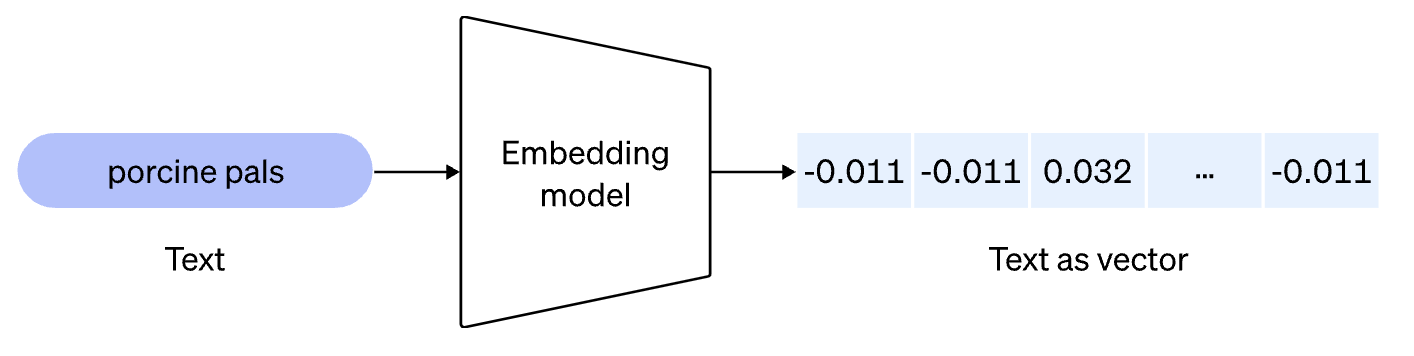


RAG enables LLMs to access dynamic external knowledge without modifying the model parameters. 

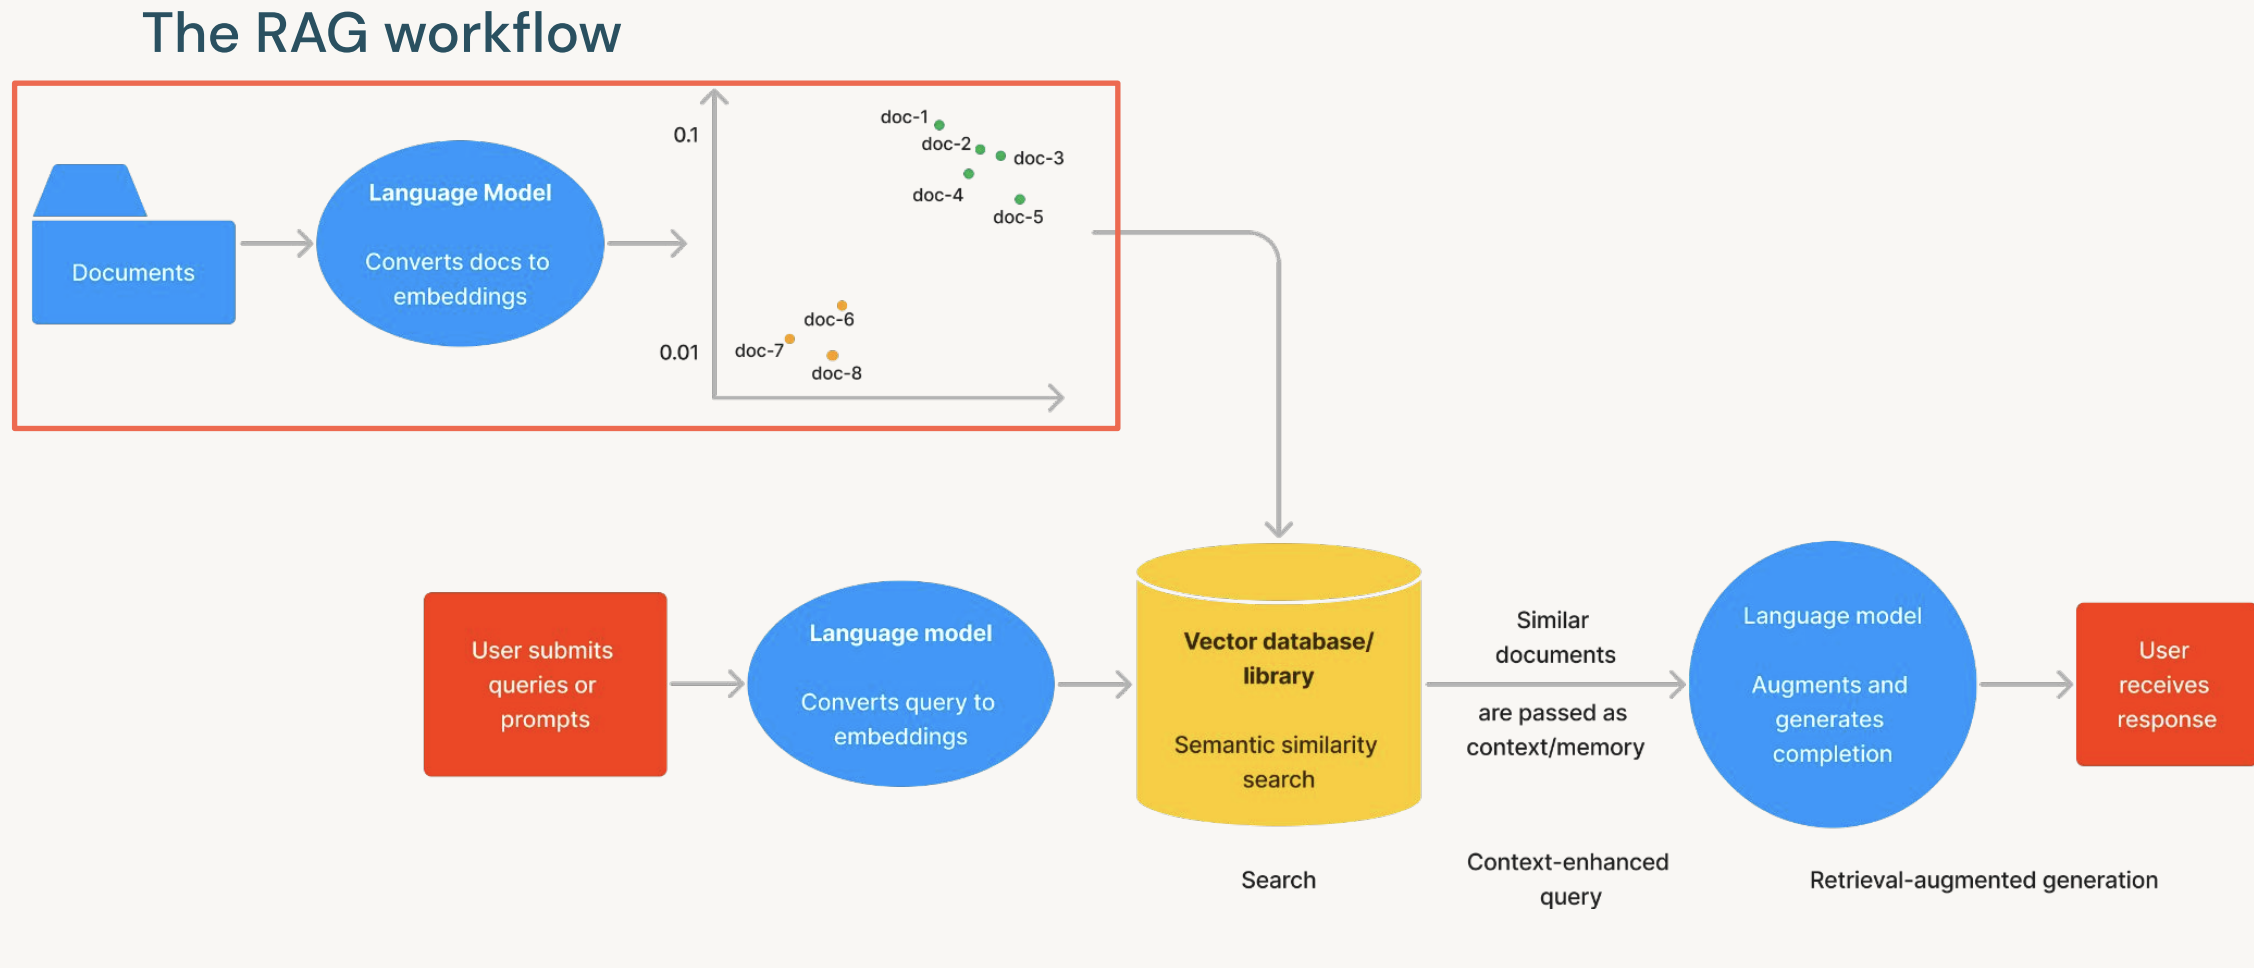

Using LLMs to generate synthetic data for diverse range of embedding tasks in 93 languages. These embedding tasks include, similar news articles, item recommendation, discover new music based on listening history on spotify etc. 

a) Synthetic Data Generation

Adopt a 2-step prompting strategy using `GPT-4`: 

1. Prompt the LLM to brainstorm a pool candidate tasks
2. Generate data conditioned on the given task

Asymmetric and symmetric. 

In asymmetric tasks, the query and document are semantically related but not identical in wording. They don't necessarily paraphrase each other exactly.

Examples: A search engine where a user might enter a short query ("best pizza places") and the system retrieves relevant documents that might be longer descriptions of restaurants (not phrased exactly as the query).

In symmetric tasks, the query and document have similar semantic meaning but use different surface forms (wording). They are essentially paraphrases of each other.

Examples: Comparing the semantic similarity of two sentences like "The weather is pleasant today" and "It's a nice day outside."
Finding documents in a different language that convey the same meaning as a document in another language (e.g., translating a news article and finding similar articles in another language).


b) Training  

Given a relevant query-document pair `(q+, d+)`, we first apply the following instruction template to the original query `q+` to generate a new one `q+inst`. Instruction Template: A template is applied to the original query. This template includes:
Task Definition: A one-sentence description of the task (e.g., "Find semantically similar documents").

A pre-trained large language model (LLM) is used and an End-of-Sequence Token: "[EOS]" token is added to both the query and document.

Document Side: The document remains unmodified. This allows for pre-building the document index and customizing the task by only changing the query side.

- Feeding to LLM: The modified query and document are fed into the LLM.

The model is trained by iteratively presenting it with data pairs, calculating the contrastive loss, and updating its internal parameters (weights and biases) to minimize the loss. This process helps the model learn to distinguish similar and dissimilar data points and develop meaningful representations.

Mistral-7B when fine-tuned on synthetic data, attains competitive performance on BEIR and MTEB benchmarks only on synthetic data without any labeled data. Model achieves +2% on a mixture of labeled and synthetic data. Entire training process requires < 1k steps. 

- Embedding Extraction: The last hidden layer vector corresponding to the "[EOS]" token is extracted for both the query and document, resulting in embeddings `hq inst+` and `hd+`.

Loss Function: A contrastive loss function is employed. This function penalizes the model when it fails to pull similar pairs closer or push dissimilar pairs further apart in a latent space (a high-dimensional representation of the data). Common choices include `InfoNCE loss` or Triplet loss.

**Conclusion:**

The quality of text embeddings can be substantially enhanced by exploiting LLMs by prompting LLMs such as `GPT-4` to generate diverse synthetic data. Combined with strong language understanding capability of Mistral model, we establish new SOTA results on competitive MTEB benchmark.  

**Pros vs cons**

|                 | Multi-stage    | Single-stage |
|-----------------|-----------------|-----------------|
| Engineering Efforts | High. pre-train on billions of text pairs. | Low. High quality sample dataset |
| Data collection | Manual | Synthetic |
| Reliabilty on prompts | None | Relies on prompt templates |

**Implementation - Q&A use-case - Acronis backup solution**



Applying the research and methods from the paper to our use-case for Q&A for customers who may have technical question about Acronis backup solution product.

Broadly speaking there are 3 steps involved in fine-tuning an embedding model. 

1. Preparing the data (using llamaindex generate_qa_embedding_pairs function makes this easy)

2. Finetuning the model

3. Evaluating the model on a validation knowledge corpus

For the Acronis Q&A use-case; we can leverage the mistral-7B-instruct[1] which is fine-tuned specifically for text generation and Q&A nlp tasks and propt-template for chat like interface. 

1 https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2

2 https://huggingface.co/docs/transformers/main/chat_templating

DATA PREPARATION

1. Load, chunk and index data

In [13]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter, HTMLHeaderTextSplitter

In [18]:
#!pip install langchain_text_splitters
#!pip install lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 489.5 kB/s eta 0:00:00a 0:00:04


In [21]:
url = "https://www.cnn.com/2023/09/25/weather/el-nino-winter-us-climate/index.html"

headers_to_split_on = [
    ("h1", "Header 1"),
    ("h2", "Header 2"),
]

html_splitter = HTMLHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
html_header_splits = html_splitter.split_text_from_url(url)
print(html_header_splits[1].page_content[:500])

No two El Niño winters are the same, but many have temperature and precipitation trends in common.  
Average conditions during an El Niño winter across the continental US.  
One of the major reasons is the position of the jet stream, which often shifts south during an El Niño winter. This shift typically brings wetter and cooler weather to the South while the North becomes drier and warmer, according to NOAA.  
Because the jet stream is essentially a river of air that storms flow through, they c


In [3]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000)
splits = text_splitter.split_documents(docs)

In [4]:
splits

[Document(page_content='OK', metadata={'source': 'https://www.yahoo.com/'})]

2. Generate synthetic data

In [63]:
from llama_index.finetuning import generate_qa_embedding_pairs
from llama_index.core.evaluation import EmbeddingQAFinetuneDataset
from llama_index.llms.openai import OpenAI

In [60]:
import os

OPENAI_API_TOKEN = "sk-"
os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN

In [ ]:
# Generate Q&A pairs
train_dataset = generate_qa_embedding_pairs(
    llm=OpenAI(model="gpt-3.5-turbo"), nodes=train_nodes
)
val_dataset = generate_qa_embedding_pairs(
    llm=OpenAI(model="gpt-3.5-turbo"), nodes=val_nodes
)

train_dataset.save_json("train_dataset.json")
val_dataset.save_json("val_dataset.json")

In [ ]:
train_dataset = EmbeddingQAFinetuneDataset.from_json("train_dataset.json")
val_dataset = EmbeddingQAFinetuneDataset.from_json("val_dataset.json")

2: FINE-TUNING using llamaindex

In [ ]:
import torch
import json
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import get_peft_config, get_peft_model, LoraConfig

# Hyper-parameters
BATCH_SIZE = 2048
learning_rate = 1e-4
warmup_steps = 100
epochs = 1  # Adjust for desired number of epochs
weight_decay = 0.1
lora_rank = 16
max_len = 512

# Load model
model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id, token=os.environ['HF_TOKEN'])
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0}, token=os.environ['HF_TOKEN'])

In [ ]:

with open(TRAIN_DATASET_FPATH, 'r+') as f:
    train_dataset = json.load(f)

with open(VAL_DATASET_FPATH, 'r+') as f:
    val_dataset = json.load(f)
dataset = train_dataset

corpus = dataset['corpus']
queries = dataset['queries']
relevant_docs = dataset['relevant_docs']

In [ ]:
examples = []
for query_id, query in queries.items():
    node_id = relevant_docs[query_id][0]
    text = corpus[node_id]
    example = InputExample(texts=[query, text])
    examples.append(example)

In [ ]:
loader = DataLoader(
    examples, batch_size=BATCH_SIZE
)

In [ ]:
# Define Loss
def info_nce_loss(positive_scores, negative_scores, temperature=0.1):
  # ... 
  return loss


In [ ]:
# Run Training
model.fit(
    train_objectives=[(loader, loss)],
    epochs=EPOCHS,
    warmup_steps=warmup_steps,
    output_path='exp_finetune',
    show_progress_bar=True,
    evaluator=evaluator, 
    evaluation_steps=50,
)

In [ ]:
# Calculate cosine similarity
temperature=0.2
df["cosine_similarity"] = torch.nn.functional.cosine_similarity(df["query_embedding"], df["document_embedding"])
df["scaled_cosine_match_scores"] = df["cosine_similarity"] / temperature

2: FINE-TUNING

When do you need to fine-tune embedding models?

The answer lies in the specific requirements of your project and the unique characteristics of your data. Embedding models, such as word2vec, GloVe, and BERT, are powerful tools that can capture the semantic relationships and contextual information within your data. However, these pre-trained models are often developed on large, general-purpose datasets, which may not fully align with the nuances and idiosyncrasies of your particular use case.

⚙️By fine-tuning these embedding models on your specific dataset, you can tailor the representations to better suit your needs, improving the accuracy, relevance, and performance of your downstream tasks.
Whether you're working on natural language processing, computer vision, or any other domain, the process of fine-tuning your embedding models can be a game-changer.

⏩Optimizing your embedding models for faster inference and better performance can give you a crucial edge over your competitors.

🎯By exploring techniques like quantization, pruning, and knowledge distillation, you can streamline your models, reducing their memory footprint and inference latency without sacrificing accuracy.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Define the embedding model
class EmbeddingModel(nn.Module):
    def __init__(self, input_dim):
        """
        In the constructor (__init__ method), it initializes a linear layer (nn.Linear) to learn the embeddings.
        
        super(EmbeddingModel, self).__init__() calls the constructor of the parent class nn.Module. 
        This is necessary because EmbeddingModel is inheriting from nn.Module, and we want to ensure that the initialization logic defined in the parent class is also executed when creating instances of EmbeddingModel.
        
        """
        super(EmbeddingModel, self).__init__()
        
        """
        A linear layer, represented by nn.Linear in PyTorch, is a fully connected layer that performs a linear transformation on its input.
        
        It takes an input tensor of shape (batch_size, input_dim) and produces an output tensor of shape (batch_size, output_dim) by applying a linear transformation followed by an optional bias.
        The linear transformation involves multiplying the input tensor by a weight matrix and adding a bias vector.
        """
        self.embedding = nn.Linear(input_dim, 1)

    """
    The forward pass refers to the process of passing input data through the network to generate predictions or activations.
    During the forward pass, input data is sequentially passed through the layers of the network, starting from the input layer, through the hidden layers, and finally to the output layer.
    Each layer performs a specific operation (e.g., linear transformation, activation function) on the input data and passes the result to the next layer.
    
    In PyTorch, the forward pass is defined by implementing the forward method in a subclass of nn.Module. This method specifies how input data should be processed to produce output predictions or activations.
    The forward method typically applies the layer operations defined in the constructor (__init__ method) to the input data in a sequential manner, propagating the data through the network layers.
    """

    def forward(self, query_emb, doc_emb):
        similarity_scores = torch.cosine_similarity(query_emb, doc_emb, dim=1)
        return similarity_scores


# Set test size (e.g., 20% for testing)
test_size = 0.2

# Split the DataFrame into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=test_size, random_state=42)

# Create separate DataFrames for train and test sets
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})


# Initialize model and optimizer
input_dim = train_df['query_embeddings'].shape[1]  # Dimension of embeddings
model = EmbeddingModel(input_dim)

"""
Adam optimizer is used to update the parameters of the embedding model during training.
"""
optimizer = optim.Adam(model.parameters(), lr=0.001)

# temperature adjusts the scaling of the similarity scores
temperature = 0.1

# Define loss function or define a customer class / function for calculating InfoNCELoss
loss_fn = nn.CrossEntropyLoss()

"""
The training loop to fine-tune the embedding model.

Iterate over a fixed number of epochs, during which the model parameters are updated to minimize the InfoNCE loss.

Inside each epoch, it performs a forward pass to compute the embeddings, calculates the loss, performs a backward pass to compute gradients, and updates the model parameters using the optimizer.
Prints the loss at each epoch to monitor
"""

num_epochs = 10

# Fine-tune the model
for epoch in range(num_epochs):
    model.train()
    for batch in train_data_loader:
        query_emb = batch['query_embeddings']
        doc_emb = batch['doc_embeddings']

        # Compute similarity scores with scaled cosine similarity
        similarity_scores = model(query_emb, doc_emb) / temperature

        # Compute loss
        labels = torch.zeros(len(batch), dtype=torch.long)  
        loss = loss_fn(similarity_scores, labels)

        # Backpropagation

        # set gradients of all model parameters to zero
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


# Evaluate the model
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        query_emb = batch['query_embeddings']
        doc_emb = batch['doc_embeddings']

        # Compute similarity scores
        similarity_scores = model(query_emb, doc_emb) / temperature
        
        # Perform evaluation (e.g., accuracy, precision, recall)
        ...


3. EVALUATION

https://docs.llamaindex.ai/en/stable/examples/finetuning/embeddings/finetune_embedding.html#evaluate-finetuned-model

Common Eval metrics for Q&A / Text generation: 

1. Perplexity - measures the average uncertainty of a language model when predicting text. Calculated as inverse probability of the test set, normalized by the number of words.

2. BLEU - Evaluates the quality of generated text by comparing it to reference text. https://cloud.google.com/translate/automl/docs/evaluate#bleu
   
3. ROGUE - Measures overlap between generated text and reference text.
https://huggingface.co/spaces/evaluate-metric/rouge

BLEU and ROGUE are calculated based n-gram overlap between generated and reference text

4. Accuracy - proportion of correctly answered questions.
   
5. F1 Score - harmonic mean of precision and recall.

Precision: proportion of predicted positive cases that are actually positive.
Recall: proportion of actual positive cases that are correctly identified by your model. 

Example: 
Precision = TP / (TP + FP), 
Recall = TP / (TP + FN) 

F1 score = 2 * (Precision * Recall) / (Precision + Recall).

6. Hit rate

HR = Number of searches with at least one relevant document in Top k / Total number of searches

For reference, 

a) **BEIR** (BEmBench for Information Retrieval):

Evaluates the effectiveness of models in retrieving relevant documents for a given information need (query).

Metrics: Uses various metrics like Mean Reciprocal Rank (MRR), Normalized Discounted Cumulative Gain (NDCG), and Precision at k (P@k) to assess the quality of retrieved documents.

MRR: Measures how quickly the first relevant document is retrieved.

NDCG: Captures the relevance and ranking of retrieved documents.

P@k: Evaluates the proportion of relevant documents among the top k retrieved results.

Data: TREC collections

b) **MTEB** Benchmark:

Evaluates the performance of text embedding models on various natural language processing tasks.

Metrics: Utilizes multiple metrics depending on the specific task, such as:

- Accuracy: Proportion of correctly classified examples for tasks like sentiment analysis or question answering.

- F1-score: Harmonic mean of precision and recall, considering both correctly identified positive and negative cases.

- Semantic Similarity Score: Measures how well the model captures the similarity between different text pieces.

Data: Employs various datasets like SNLI (natural language inference), STS-B (semantic textual similarity), and MRPC (movie review product comparison).

Why PEFT? 

As models get larger and larger, full fine-tuning becomes infeasible to train on consumer hardware. In addition, storing and deploying fine-tuned models independently for each downstream task becomes very expensive, because fine-tuned models are the same size as the original pretrained model. Parameter-Efficient Fine-tuning (PEFT) approaches are meant to address both problems!

PEFT approaches only fine-tune a small number of (extra) model parameters while freezing most parameters of the pretrained LLMs, thereby greatly decreasing the computational and storage costs.

- https://github.com/kevalshah90/llms/blob/main/docs/examples/finetuning/embeddings/finetune_embedding.ipynb
  
- https://cookbook.openai.com/examples/embedding_wikipedia_articles_for_search
  
- https://cookbook.openai.com/examples/question_answering_using_embeddings

- https://python.langchain.com/docs/use_cases/question_answering/quickstart
  
- https://github.com/UKPLab/sentence-transformers/blob/master/examples/applications/semantic-search/semantic_search_wikipedia_qa.py
  
- https://github.com/UKPLab/sentence-transformers/tree/master/examples/applications/retrieve_rerank/retrieve_rerank_simple_wikipedia.py
  
- https://www.sbert.net/examples/applications/semantic-search/README.html#approximate-nearest-neighbor
  
- https://huggingface.co/docs/transformers/main/chat_templating
  
- https://platform.openai.com/docs/guides/embeddings/use-cases
  
- https://github.com/embeddings-benchmark/mteb
  
- https://cookbook.openai.com/examples/vector_databases/chroma/using_chroma_for_embeddings_search
  
- https://huggingface.co/blog/peft

**RAG Implementation using vector DBs**

In [ ]:
import chromadb
from chromadb.config import Settings

In [ ]:
chroma_client = chromadb.Client(
    Settings(
        chroma_db_impl="duckdb+parquet",
        persist_directory=DA.paths.user_db,  # this is an optional argument. If you don't supply this, the data will be ephemeral
    )
)

In [ ]:
# create a collection
collection_name = "acronis"

print(f"Creating collection: '{collection_name}'")
collection = chroma_client.create_collection(name=collection_name)

In [ ]:
# Add the synthetic data generated from langchain document loader to the collection with an INDEX

collection.add(
    documents=df["title"][:100].tolist(),
    metadatas=[{"topic": topic} for topic in pdf_subset["topic"][:100].tolist()],
    ids=[f"id{x}" for x in range(100)],
)

In [ ]:
# Query collection
results = collection.query(query_texts=["Trial period?"], n_results=5)

In [ ]:
# Create a text generation pipeline and prompt

pipe = pipeline(
    "text-generation",
    model=model, # replace with fine-tuned model
    tokenizer=tokenizer,
    max_new_tokens=8000, # context length
    device_map="auto",
)

In [ ]:
# Ask question, apply a prompt template
question = "How quickly can the software restore data during a crisis?"
context = " ".join([f"#{str(i)}" for i in results["documents"][0]])
prompt_template = f"Relevant context: {context}\n\n The user's question: {question}"

In [ ]:
# return/print result
lm_response = pipe(prompt_template)
print(lm_response[0]["generated_text"])

In [79]:
"""
Embedding dimension are based on the specific architecture used to train the model.  

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2 

The `all-MiniLM-L6-v2` sentence-transformers model maps sentences & paragraphs to a 384 dimensional dense vector space and 
can be used for tasks like clustering or semantic search.
"""

from sentence_transformers import SentenceTransformer

# Choose a pre-trained sentence transformer model (replace if needed)
model_name = "all-MiniLM-L6-v2"  # Example model, choose based on your task

# Load the SentenceTransformer model
model = SentenceTransformer(model_name)

# Define your list of sentences
sentences = ["query [EOS] doc_text", "This is another sentence to be encoded."]

# Encode the sentences using the model
embeddings = model.encode(sentences)

In [76]:
for i, e in enumerate(embeddings):
    print(f"index {i}")
    print(f"embeddings {e}")
    print(f"Length {len(e)}")

index 0
embeddings [ 9.81245860e-02  6.78126514e-02  6.25231490e-02  9.50848237e-02
  3.66475992e-02 -3.98464967e-03  7.47755449e-03 -1.32314833e-02
  6.28836825e-02  2.24954840e-02  7.26957917e-02 -3.12742405e-02
  4.63551506e-02 -1.25544742e-02  4.78147715e-02 -4.91031306e-03
  4.94199321e-02 -6.41093031e-02 -9.69658867e-02  3.28887925e-02
  5.41044921e-02  3.53285633e-02  3.30505520e-02  1.46993874e-02
 -3.34305987e-02 -2.56158654e-02 -5.07921427e-02  7.32545480e-02
  1.10274032e-01 -2.96618380e-02 -6.75570294e-02 -3.05715185e-02
  3.95602696e-02  4.54760231e-02  1.59961618e-02  3.85503881e-02
 -1.09541127e-02  8.48356411e-02 -4.42870893e-02 -6.79639587e-03
  9.42565873e-03  5.06610704e-05  1.30350806e-03 -1.19697703e-02
  1.36451749e-02 -8.41742381e-02 -1.65144753e-04  5.48376888e-03
  2.56150849e-02 -3.15453224e-02 -1.07344724e-01 -4.57877703e-02
 -9.11748931e-02 -2.51055765e-03  1.79984123e-02  4.94016334e-02
  6.18480332e-03  5.97962961e-02  2.70026047e-02 -1.61222573e-02
 -1.81